ประกาศตัวแปร

In [25]:
ROOT_PATH = "~/ChestXray-14/results/confusion"

เลือกโมเดลที่ต้องการ

In [26]:
fold_num = 3
model_name = f"EfficientNetB0_None_fold_{fold_num}"

อ่านจากไฟล์ประวัติ Threshold เทียบกับ Confusion metrics ของแต่ละโมเดล

In [27]:
import numpy as np
import pandas as pd
from modules.dataset import LABELS

In [28]:
def preprocessing_data(x):
    if "e+" in x:
        values = eval(x.replace(" ", ", "))
        return np.array(values)
    else:
        values = eval(x.replace("\n", "").replace(". ", ".,"))
        return np.array(values)

In [29]:
df = pd.read_csv(f"{ROOT_PATH}/{model_name}.csv")
thresholds = df["thresholds"].values
TP = df["TP"].apply(preprocessing_data).values
TN = df["TN"].apply(preprocessing_data).values
FP = df["FP"].apply(preprocessing_data).values
FN = df["FN"].apply(preprocessing_data).values

แสดงผล

In [30]:
f1_thresholds_dict = dict()
for i_thresh, (tps, tns, fps, fns) in enumerate(zip(TP, TN, FP, FN)):
    for label, tp, tn, fp, fn in zip(LABELS, tps, tns, fps, fns):
        f1_score = 2*tp / (2*tp + fp + fn)
        try: 
            f1_thresholds_dict[label].append((thresholds[i_thresh], f1_score))
        except:
            f1_thresholds_dict[label] = [(thresholds[i_thresh], f1_score)]

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [32]:
def plot_compare(dictionary, name, x_label, y_label):
    plt.figure(figsize=(20,12))
    best_multiple_f1_list = []
    for i, (label, value) in enumerate(dictionary.items()):
        x, y = zip(*value)
        plt.plot(x, y, marker='.', label=label)
        
        y = np.array(y)
        best = y.argmax()
        sns.scatterplot(x=[x[best]], y=[y[best]], marker="X", s=300)
        
        best_multiple_f1_list.append(x[y.argmax()])

    plt.title(name)
    plt.legend()
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, fontweight='bold')
    plt.ylim(-0.05, 1.05)
    plt.xlim(-0.05, 1.05)
    plt.show()
    return best_multiple_f1_list

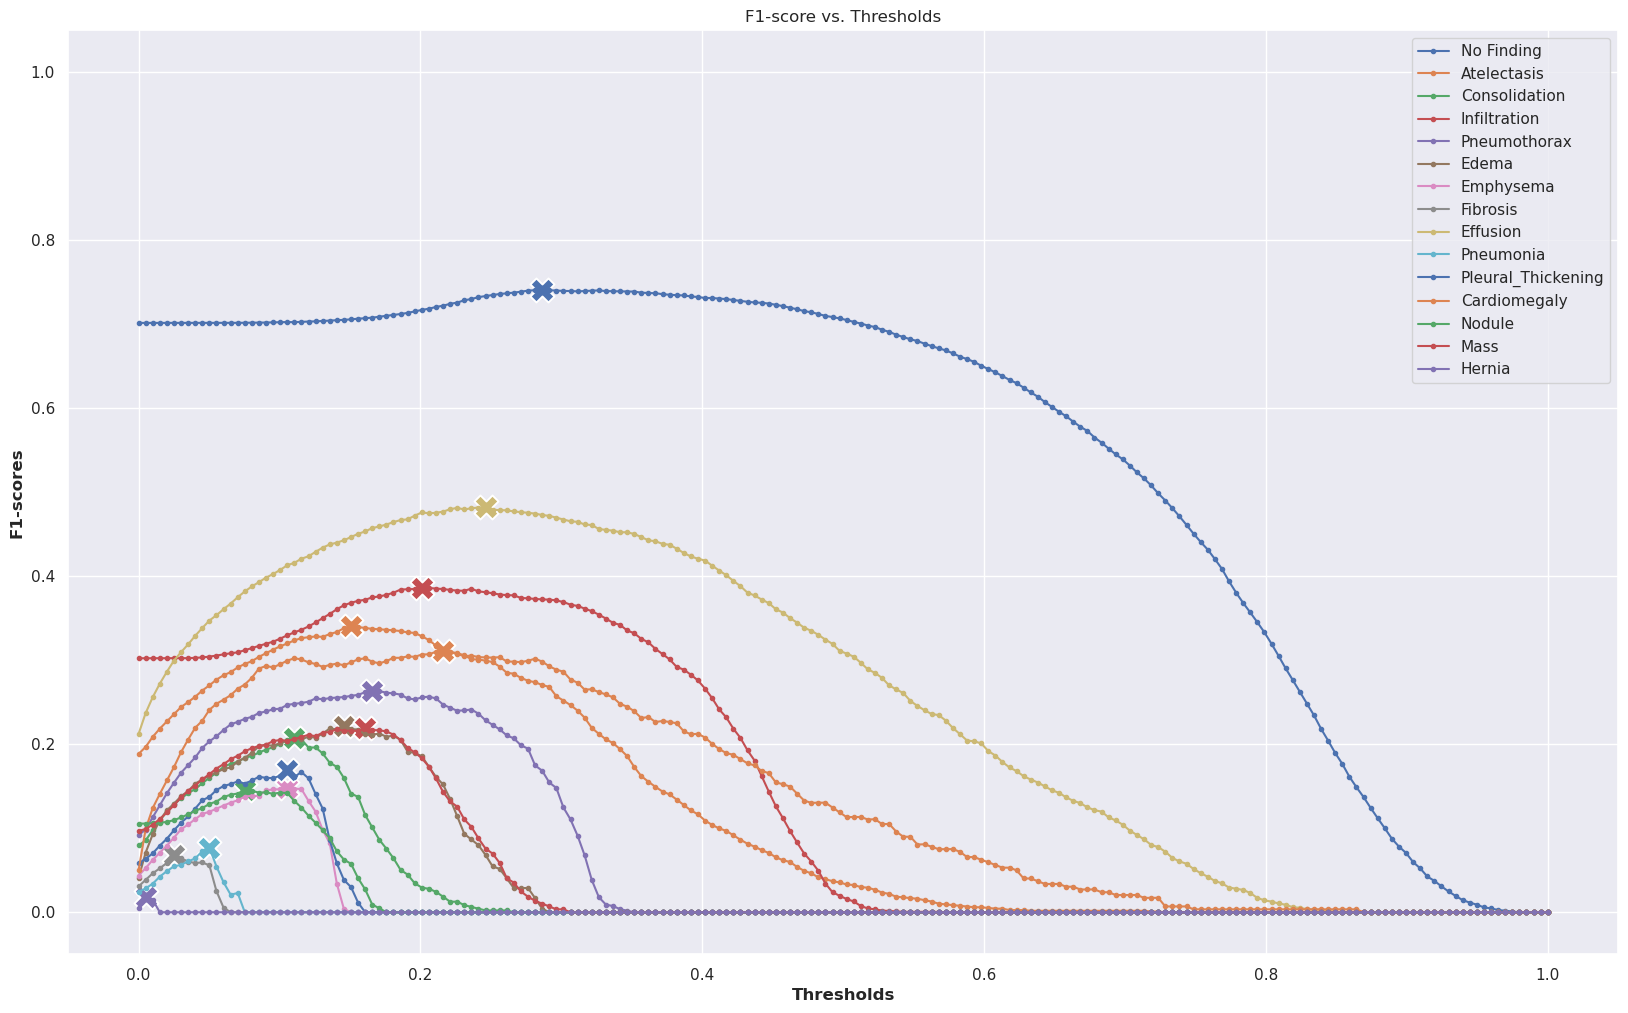

In [33]:
best_multiple_threshold = plot_compare(f1_thresholds_dict, name="F1-score vs. Thresholds", x_label='Thresholds', y_label='F1-scores')

In [34]:
best_multiple_threshold

[0.2864321608040201,
 0.1507537688442211,
 0.1105527638190954,
 0.2010050251256281,
 0.1658291457286432,
 0.1457286432160804,
 0.1055276381909547,
 0.0251256281407035,
 0.2462311557788944,
 0.050251256281407,
 0.1055276381909547,
 0.2160804020100502,
 0.0753768844221105,
 0.1608040201005025,
 0.0050251256281407]

ลองทำนายด้วยค่า Multiple threshold

In [35]:
def get_y_true(data):
    y_true=[]
    for X,y in data:
        for label in y:
            y_true.append(label)
    y_true = tf.Variable(y_true)
    return y_true

In [36]:
import tensorflow as tf
from modules.dataset import Dataset

In [37]:
dataset = Dataset()

# Dataset
train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=False)

# Get y_true
y_true = get_y_true(test_dataset)

model_name = f"EfficientNetB0_None_fold_{fold_num}"

# Modeling
model = tf.keras.models.load_model(f"results/models/{model_name}.h5")

In [38]:
y_preds = model.predict(test_dataset)

1402/1402 [==============================] - 39s 27ms/step


In [39]:
y_preds

array([[3.7310052e-01, 1.6924858e-01, 9.9674374e-02, ..., 4.1000951e-02,
        4.1726671e-02, 3.5352266e-04],
       [5.8590525e-01, 2.7905747e-02, 1.3990472e-02, ..., 8.4902428e-02,
        5.7840213e-02, 1.2998409e-03],
       [5.7264221e-01, 5.4535806e-02, 4.2026330e-02, ..., 4.1515775e-02,
        1.7248476e-02, 7.9101539e-04],
       ...,
       [8.3739376e-01, 2.8178548e-02, 7.1744937e-03, ..., 4.0017873e-02,
        2.4414366e-02, 2.4765448e-04],
       [8.5998893e-01, 1.0379186e-02, 4.0106531e-03, ..., 1.8507335e-02,
        3.7539245e-03, 2.6685186e-04],
       [5.4743415e-01, 1.8109280e-01, 4.3049961e-02, ..., 5.2635297e-02,
        4.7152814e-02, 3.4806065e-03]], dtype=float32)

In [40]:
!pip install tensorflow_addons

In [41]:
best_multiple_threshold

[0.2864321608040201,
 0.1507537688442211,
 0.1105527638190954,
 0.2010050251256281,
 0.1658291457286432,
 0.1457286432160804,
 0.1055276381909547,
 0.0251256281407035,
 0.2462311557788944,
 0.050251256281407,
 0.1055276381909547,
 0.2160804020100502,
 0.0753768844221105,
 0.1608040201005025,
 0.0050251256281407]

In [51]:
import seaborn as sns
from modules.dataset import LABELS
import matplotlib.pyplot as plt

def plot_confusion_metics(confusion_metrics, threshold):
    fig = plt.figure(figsize=(35,20))
    fig.suptitle(f"Condusion Metrics for Threshold: {threshold[:5]}\n{threshold[5:10]}\n{threshold[10:]}", fontsize=30)
    for i, confusion_metrix in enumerate(confusion_metrics.numpy().astype('int64')):
        plt.subplot(3, 5, i+1)
        plt.title(LABELS[i], fontweight='bold', fontsize=16)
        sns.heatmap(confusion_metrix, cbar=False, annot=True, fmt="d", cmap="Greens", linewidths=.5, annot_kws={"fontsize":24})
        plt.xlabel('predicted label', fontweight='bold')
        plt.ylabel('actual label', fontweight='bold')
    

In [52]:
import numpy as np
import tensorflow_addons as tfa

def run_confusion_metrics():
    fig = plt.figure(figsize=(35,20))
    thresh_value = best_multiple_threshold
    metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
    metric.update_state(y_true,
                        np.greater_equal(y_preds, thresh_value).astype('int8'))
    result = metric.result()
    plot_confusion_metics(result, thresh_value)
    plt.show()
    return result

<Figure size 3500x2000 with 0 Axes>

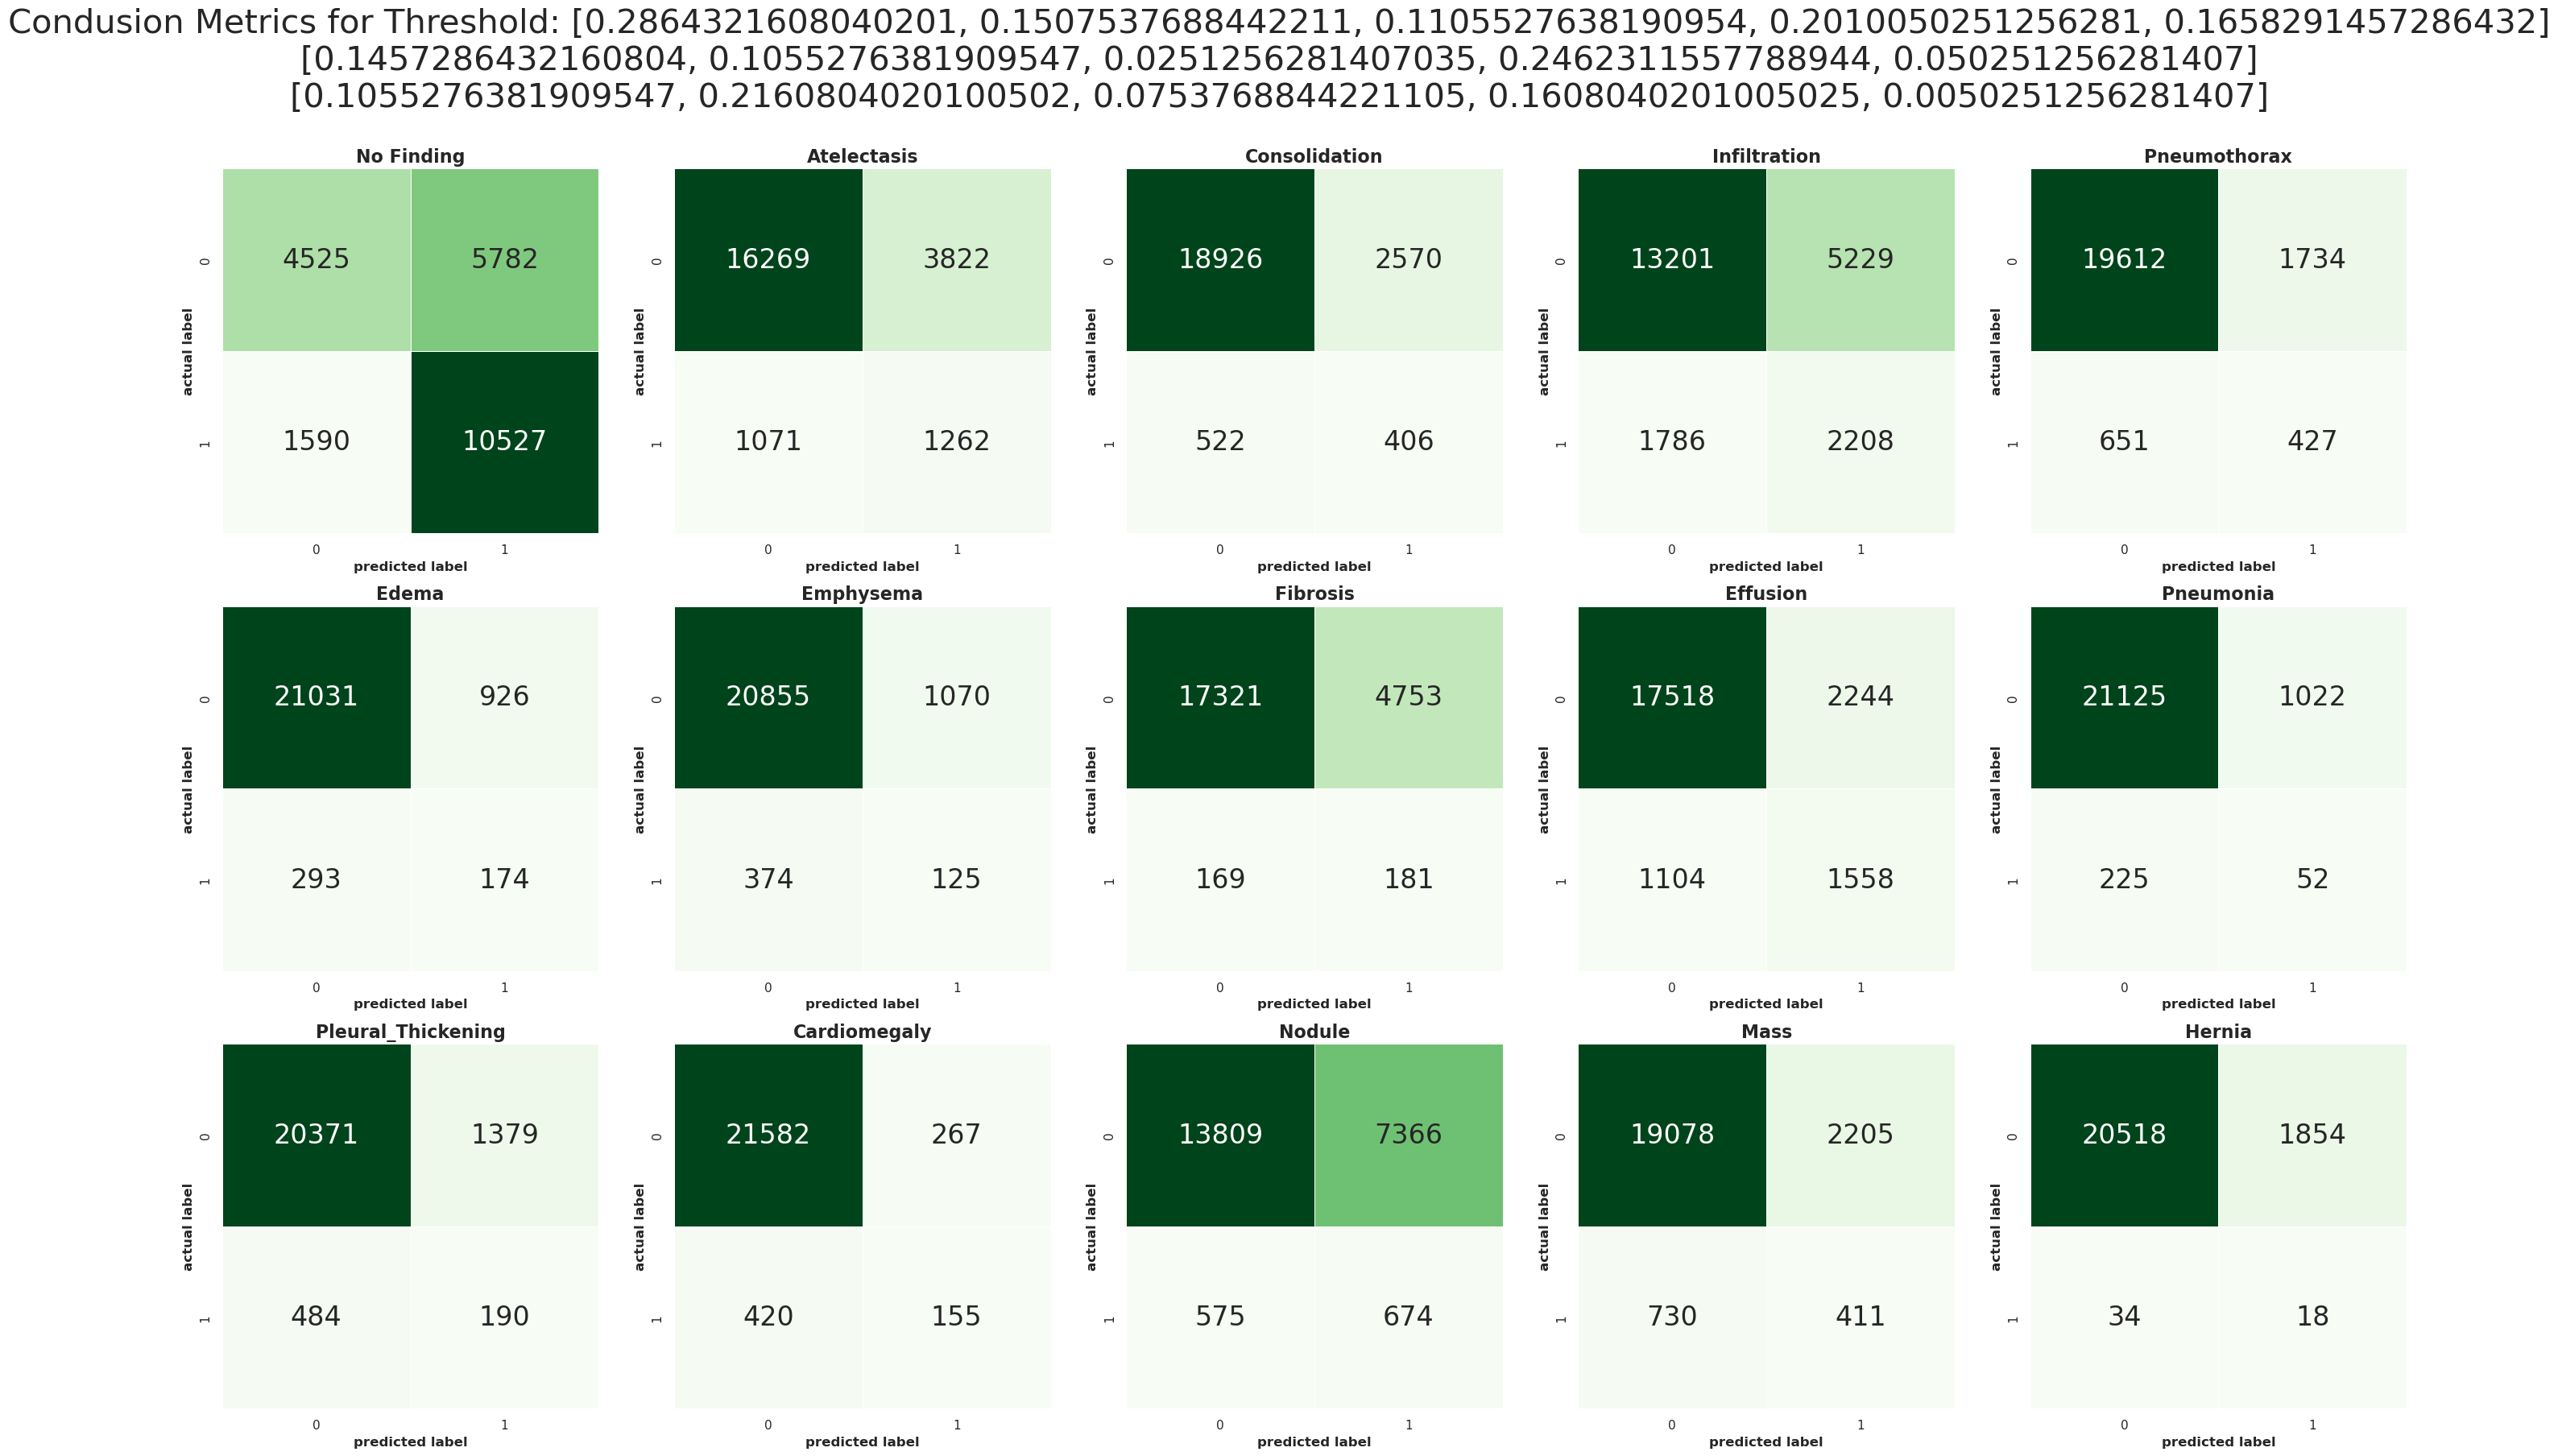

In [55]:
result = run_confusion_metrics()

Describe `tmp`
``` python
TN = tmp[0][0][0]
FP = tmp[0][0][1]
FN = tmp[0][1][0]
TP = tmp[0][1][1]
```

In [76]:
tmp = result.numpy()
tmp[0]

array([[ 4525.,  5782.],
       [ 1590., 10527.]], dtype=float32)

In [122]:
from modules.dataset import LABELS

accuracy = []
for i in range(len(tmp)):
    ls = (tmp[i][1][1] + tmp[i][0][0]) / (tmp[i][1][1] + tmp[i][0][0] + tmp[i][0][1] + tmp[i][1][0])
    accuracy.append(ls)
    print(f"{LABELS[i]} : {accuracy[i]*100} %")


No Finding : 67.12450981140137 %
Atelectasis : 78.17962765693665 %
Consolidation : 86.2112045288086 %
Infiltration : 68.71655583381653 %
Pneumothorax : 89.36407566070557 %
Edema : 94.56385970115662 %
Emphysema : 93.56046915054321 %
Fibrosis : 78.05030345916748 %
Effusion : 85.06956696510315 %
Pneumonia : 94.43899393081665 %
Pleural_Thickening : 91.69193506240845 %
Cardiomegaly : 96.93631529808044 %
Nodule : 64.58705067634583 %
Mass : 86.91134452819824 %
Hernia : 91.58045053482056 %


In [125]:
accuracy

[0.6712451,
 0.7817963,
 0.86211205,
 0.68716556,
 0.89364076,
 0.9456386,
 0.9356047,
 0.78050303,
 0.85069567,
 0.94438994,
 0.91691935,
 0.96936315,
 0.6458705,
 0.86911345,
 0.9158045]